### Competition aim and summary of our project

The project involved a competition between groups of students from the master's program to predict whether movie reviews on IMDb were positive or negative. The data provided by the professors was intentionally made dirty and unorganized to better represent a real-world scenario. The aim of the competition was to test our skills in:

- cleaning and preprocessing data using Pyspark,
- finding and scraping additional data online and merging it with the existing data, and
- using machine learning techniques to create an innovative and performant model on the competition's validation and test sets.

First, we successfully cleaned and preprocessed the data, which can be found in this notebook: https://github.com/Matei9721/Big-Data-Project/blob/feature/pipeline/notebooks/data_cleaning.ipynb. 
The variables that we used in our machine learning model were: 'runtime minutes of the movie,' 'number of votes (reviews),' and 'year of the movie.'

We then collected three new variables: 'plots' of the movies, 'awarded' movies, and 'genres.' We extracted the 'plots' and 'awards' using GPT-3, with a prompt containing the movie's title, minutes, and year. The 'genre' variable was extracted from an online dataset that scraped Wikipedia.

Here comes the fun ML part!! I trained a BERT model using just the 'plots' variable, while all the remaining features were used to train a Light Gradient Boosting Model (LGBM). Initially, I used the output of the BERT model (first tried with labels, then found out that raw probabilities were better) to create a new feature, which I added to the LGBM. This gave us a high accuracy of 81% on the competition's validation and testing sets. However, our accuracy on the test set that came from our train-test split was 10% higher than the competition's due to data leakage.

To solve this issue, I made the models independent and computed predictions for both models, which I then averaged (essentially, I was doing ensembling). This approach improved the accuracy on the competition's test set to 82.5%. To further improve the accuracy, I decided to use four different BERT models instead of just one, resulting in ensembling five models (four BERTs and one LGBM) and a final accuracy of 84%, outperforming all other groups by 3.5%.

The code for the machine learning pipeline can be found below. Please note that I have removed or simplified certain parts to better showcase the pipeline to the reader.

P.S. The GitHub repo of the complete project is here: https://github.com/Matei9721/Big-Data-Project/tree/feature/pipeline


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Prepare text data for the Bert model

In [66]:
train = pd.read_csv('/kaggle/input/train-val-test-bert/train.csv')

In [67]:
#change label type
train['label'] = train['label'].astype(int)

In [68]:
train = train[['plot', 'label']]
train.head()

,plot,label
0,the doll is a 1919 silent film directed by e...,1
1,the way down east is a 1920 silent film dire...,1
2,destiny is a 1921 german silent fantasy film...,1
3,the navigator is a 1924 silent comedy film s...,1
4,the phantom of the opera is a 1925 silent ho...,1


In [6]:
#see if null values
train.info()abs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7959 entries, 0 to 7958
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   plot    7959 non-null   object
 1   label   7959 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 124.5+ KB


min length: 366 
max length: 776


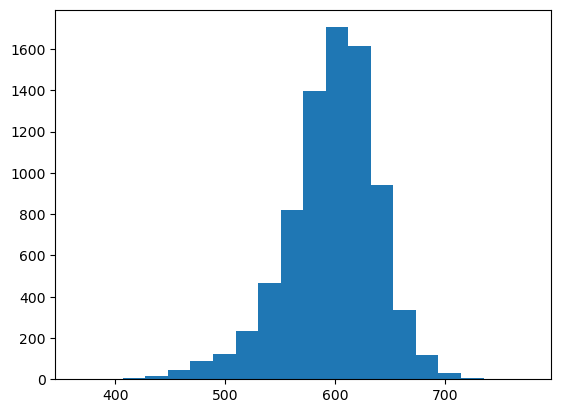

In [7]:
#see distribution of characters in plots. 
#The less the variance the less truncation and padding will be done and bert will perform better
lengths = []
for i, sentence in enumerate(train['plot']):
    lengths.append(len(sentence))
    
plt.hist(lengths, bins=20);  
print('min length:', min(lengths),'\nmax length:',max(lengths))  

In [37]:
#NEW TRAIN TEST SPLIT (this randomization is the same for this notebook and the lightgbm notebook)
train = train.sample(frac=1, random_state=420).reset_index(drop=True)
train.head()

,plot,label
0,"in 1968, a small town in the midwest is rock...",0
1,hawaizaada is a 2015 indian biographical dra...,0
2,the beverly hillbillies is a 1993 comedy fil...,0
3,the man who came to dinner is a 1942 comedy ...,1
4,the black godfather is a biographical drama ...,1


In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [9]:
# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Example movie plot
plot = list(train['plot'].values)[0]
plot = "A young woman falls in love with a man who is secretly a prince."

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the plot using the tokenizer's encode() method
tokens = tokenizer.encode(plot, add_special_tokens=True)

# The tokens variable now contains the token IDs of the tokenized plot
print('Original plot:', plot)
print()
print('Tokenized plot:', tokenizer.convert_ids_to_tokens(tokens))
print()
print('Token IDs:', tokens)

Original plot: A young woman falls in love with a man who is secretly a prince.

Tokenized plot: ['[CLS]', 'a', 'young', 'woman', 'falls', 'in', 'love', 'with', 'a', 'man', 'who', 'is', 'secretly', 'a', 'prince', '.', '[SEP]']

Token IDs: [101, 1037, 2402, 2450, 4212, 1999, 2293, 2007, 1037, 2158, 2040, 2003, 10082, 1037, 3159, 1012, 102]


In [11]:
max_len = 128 # maximum sequence length to use

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#encoded_plots = tokenizer.batch_encode_plus(list(train['plot'].values), add_special_tokens=True, max_length=max_len, pad_to_max_length=True, truncation=True, return_attention_mask=True, return_tensors='pt')
encoded_plots = tokenizer.batch_encode_plus(list(train['plot'].values), add_special_tokens=True, max_length=max_len, 
                                            padding=True, truncation=True, return_tensors='pt')

In [12]:
encoded_plots['input_ids'].shape

torch.Size([7959, 128])

In [13]:
labels_tensor = torch.tensor(train['label'])

### Old Shuffle

In [50]:
# Create a TensorDataset and DataLoader for training and validation
dataset = TensorDataset(encoded_plots['input_ids'], encoded_plots['attention_mask'], labels_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


### New shuffle (same to lightGBM)

#### we need to train Bert and the LGBM on the same split of data

In [31]:
train_size = int(0.8 * len(train))

train_dataset = TensorDataset(
    encoded_plots['input_ids'][:train_size], 
    encoded_plots['attention_mask'][:train_size], 
    labels_tensor[:train_size]
)

val_dataset = TensorDataset(
    encoded_plots['input_ids'][train_size:], 
    encoded_plots['attention_mask'][train_size:], 
    labels_tensor[train_size:]
)
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #cambiaaa
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [32]:
#test
train['label'][0:15]

0     0
1     0
2     0
3     1
4     1
5     1
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    0
14    1
Name: label, dtype: int64

In [37]:
#test
for i, batch in enumerate(train_dataloader):
    print(batch[2])
    break

tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0])


## Bert Training

In [26]:
# Load the pre-trained BERT model and add a classification layer on top of it
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [35]:
# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Fine-tune the BERT model
model.to(device)
model.train()

for epoch in range(epochs):
    for i, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad() #set the gradients to zero for each batch
        
        # forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        # backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #clip the gradients to a maximum value of 1.0, prevent exploding gradient
        
        #parameter update based on the current gradient (stored in . grad attribute of a parameter)
        optimizer.step()
        
        #update learning rate with scheduler
        scheduler.step()
        
        if i % 50 == 0:
            print(f'epoch:{epoch}, batch {i} out of {len(train_dataset)//batch_size} is done')

    # Evaluate the model on the validation set after each epoch
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            val_accuracy += torch.sum(preds == labels).item()

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_accuracy = val_accuracy / len(val_dataset)

    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


epoch:0, batch 0 out of 397 is done
epoch:0, batch 50 out of 397 is done
epoch:0, batch 100 out of 397 is done
epoch:0, batch 150 out of 397 is done
epoch:0, batch 200 out of 397 is done
epoch:0, batch 250 out of 397 is done
epoch:0, batch 300 out of 397 is done
epoch:0, batch 350 out of 397 is done
Epoch 1/2, Validation Loss: 0.5062, Validation Accuracy: 0.7745
epoch:1, batch 0 out of 397 is done
epoch:1, batch 50 out of 397 is done
epoch:1, batch 100 out of 397 is done
epoch:1, batch 150 out of 397 is done
epoch:1, batch 200 out of 397 is done
epoch:1, batch 250 out of 397 is done
epoch:1, batch 300 out of 397 is done
epoch:1, batch 350 out of 397 is done
Epoch 2/2, Validation Loss: 0.4896, Validation Accuracy: 0.7789


### Bert on ALL dataset (RUN ONLY IF YOU WANT TO TRAIN ON 100% OF DATA)

In [27]:
batch_size = 16

dataset = TensorDataset(encoded_plots['input_ids'], encoded_plots['attention_mask'], labels_tensor)

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [28]:
#check
0.8*len(dataset)//batch_size

397.0

In [29]:
# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Fine-tune the BERT model
model.to(device)
model.train()

for epoch in range(epochs):
    for i, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad() #set the gradients to zero for each batch
        
        # forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        # backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #still don't know what it does
        
        #parameter update based on the current gradient (stored in . grad attribute of a parameter)
        optimizer.step()
        
        #update learning rate with scheduler
        scheduler.step()
        
        if i % 50 == 0:
            print(f'epoch:{epoch}, batch {i} out of {len(dataset)//batch_size} is done')

    

epoch:0, batch 0 out of 497 is done
epoch:0, batch 50 out of 497 is done
epoch:0, batch 100 out of 497 is done
epoch:0, batch 150 out of 497 is done
epoch:0, batch 200 out of 497 is done
epoch:0, batch 250 out of 497 is done
epoch:0, batch 300 out of 497 is done
epoch:0, batch 350 out of 497 is done
epoch:0, batch 400 out of 497 is done
epoch:0, batch 450 out of 497 is done
epoch:1, batch 0 out of 497 is done
epoch:1, batch 50 out of 497 is done
epoch:1, batch 100 out of 497 is done
epoch:1, batch 150 out of 497 is done
epoch:1, batch 200 out of 497 is done
epoch:1, batch 250 out of 497 is done
epoch:1, batch 300 out of 497 is done
epoch:1, batch 350 out of 497 is done
epoch:1, batch 400 out of 497 is done
epoch:1, batch 450 out of 497 is done


### Save the model

In [47]:
torch.save(model.state_dict(), 'model_bert_2_AD.pth')

### Load model

In [73]:
# Define your model architecture
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Load saved model weights
model.load_state_dict(torch.load('/kaggle/working/model_bert_1_AD.pth'))

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### SUBMIT Validation/ CREATE bert_variable

Here we do two things: we compute predictions for validation and test set that we will submit to the competition. This is done to evaluate how well the bert model performs by itself in the competition. Second, we create the bert_variable. The variable consists of the raw probabilities of the model. Initially we extracted this variable and fed it to the lightGBM model as additional feature. This improved the LGBM model performance but caused data leakage. Thus, we decided to use the probabilities of the Bert model to ensemble with the lightGBM with just the original features. Ensembling avoided data leakage and improved the final accuracy on validation and test by 2.5%.

In [30]:
validation = pd.read_csv('/kaggle/input/train-val-test-bert/validation.csv')['plot']


encoded_unseen_data = tokenizer.batch_encode_plus(validation, 
                                                  add_special_tokens=True, 
                                                  max_length=max_len, 
                                                  padding=True, 
                                                  truncation=True, 
                                                  return_attention_mask=True, 
                                                  return_tensors='pt')

unseen_dataset = TensorDataset(encoded_unseen_data['input_ids'], encoded_unseen_data['attention_mask'])
unseen_dataloader = DataLoader(unseen_dataset, batch_size=batch_size)

In [31]:
import torch.nn.functional as F

model.eval()
predictions = []
bert_variable = []
with torch.no_grad():
    for batch in unseen_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, batch_predictions = torch.max(logits, dim=1)
        predictions.extend(batch_predictions.tolist())
        
        probabilities = F.softmax(logits, dim=1)[:,1] #bertvariable
        bert_variable.extend(probabilities.tolist())

In [65]:
predictions[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [21]:
bert_variable[0:10]

[0.926976203918457,
 0.9699095487594604,
 0.9733518362045288,
 0.9611004590988159,
 0.7077479958534241,
 0.9684246778488159,
 0.9697102904319763,
 0.965315580368042,
 0.9599273204803467,
 0.9443084001541138]

In [63]:
pd.DataFrame(predictions)[0].map({1:"True", 0:"False"}).to_csv("validation_predictions.csv",
                                                                    index=False, header=False)

In [33]:
pd.DataFrame(bert_variable)[0].to_csv("bert_4_validation_prob.csv", index=False, header=False)

### SUBMIT Test

#### do the same we did for validation but now for test

In [34]:
test = pd.read_csv('/kaggle/input/train-val-test-bert/test.csv')['plot']

encoded_unseen_data = tokenizer.batch_encode_plus(test, 
                                                  add_special_tokens=True, 
                                                  max_length=max_len, 
                                                  padding=True, 
                                                  truncation=True, 
                                                  return_attention_mask=True, 
                                                  return_tensors='pt')

unseen_dataset = TensorDataset(encoded_unseen_data['input_ids'], encoded_unseen_data['attention_mask'])
unseen_dataloader = DataLoader(unseen_dataset, batch_size=batch_size)

In [35]:
import torch.nn.functional as F

model.eval()
predictions = []
bert_variable = []
with torch.no_grad():
    for batch in unseen_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, batch_predictions = torch.max(logits, dim=1)
        predictions.extend(batch_predictions.tolist())
        
        probabilities = F.softmax(logits, dim=1)[:,1] #bertvariable
        bert_variable.extend(probabilities.tolist())

In [67]:
pd.DataFrame(predictions)[0].map({1:"True", 0:"False"}).to_csv("test_predictions.csv",
                                                                    index=False, header=False)

In [36]:
pd.DataFrame(bert_variable)[0].to_csv("bert_4_test_prob.csv", index=False, header=False)

# Ensemble

### LightGBM

The competition gave us 3 useful variables to predict the positive or negative reviews: "runtime minutes of the movie", "number of votes (reviews)", "year of the movie". We added two more variables:

- the "awards" variable, that was obtained similary to the plots (with gpt-3).
- "genre" variable. Since we had many genres we chose only the ones with the highest correlation to the target

Other preprocessing that was not done in this notebook but in a previous stage using spark was: binning the year variable, scaling the number of votes variable to better fill in the missing values (we found online a dataset of number of votes but 5 years later compared to the year we had, thus scaling resulted in better filling of missing values)

In [53]:
## PREPROCESS
train = pd.read_csv('/kaggle/input/train-val-test-bert/train.csv')

#drop columns
train = train.drop(['_c0', 'tconst'], axis=1)

#randomized for same train-test split for 
train = train.sample(frac=1, random_state=420).reset_index(drop=True)

#doing correlation matrix of only GENRES(indeces 18,19,20,...) and LABEL(index 4)
corr_matrix = train.iloc[:,[4] + list(range(18, train.shape[1]))].corr()

#compute list of genres to keep
genres_to_keep = abs(corr_matrix['label']).sort_values(ascending=False)[1:8].index.values

#compute all_genres, then obtain genres_to_remove by subtracting all_genres and genres_to_keep
all_genres = train.iloc[:, 18:].columns.values
genres_to_remove = set(all_genres) - set(genres_to_keep)

#drop genres_to_remove
train = train.drop(list(genres_to_remove), axis=1)

# drop titles and plot
train = train.drop(['primaryTitle', 'startYear', 'plot'], axis=1)

# change labels to int
train['label'] = train['label'].astype(int)

#view
train.iloc[0:2,:]

,runtimeMinutes,numVotes,label,awards,1915-1929,1930-1939,1940-1949,1950-1959,1960-1969,1970-1979,...,2000-2009,2010-2019,2020-2023,biography,unknown,horror,noir,drama,sci-fi,comedy
0,91,-0.233048,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,148,-0.227816,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [54]:
#NEW TRAIN TEST SPLIT
train_size = int(0.8 * len(train))

y = train["label"]
X = train.drop(["label"],axis=1)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [64]:
#useful imports
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV,cross_val_score,RepeatedStratifiedKFold,train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Create lgbm object
clf = lgb.LGBMClassifier()

# Train lgbm
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.89).astype(bool) # set threshold as 0.882 (random number)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.classification_report(y_test, y_pred))
print()
print("confusion_matrix:\n\n", confusion_matrix(y_test, y_pred))

Accuracy:               precision    recall  f1-score   support

           0       0.71      0.81      0.76       774
           1       0.79      0.69      0.74       818

    accuracy                           0.75      1592
   macro avg       0.75      0.75      0.75      1592
weighted avg       0.75      0.75      0.75      1592


confusion_matrix:

 [[624 150]
 [253 565]]


In [42]:
## Loading LightGBM model TRAINED AN ALL DATA (note that the previous one is trained on 80%)
import pickle

# Load the saved model from a file
with open('/kaggle/input/bert-probs-model-trained-all-data/lgbm_model_AD.pkl', 'rb') as f:
    clf = pickle.load(f)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.2.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [43]:
#validation and test are non labelled datasets, they are used to make predictions
#predictions are then sent to competition
validation = pd.read_csv('/kaggle/input/train-val-test-bert/validation.csv')
test = pd.read_csv('/kaggle/input/train-val-test-bert/test.csv')

#drop not useful genres
all_genres_val = validation.iloc[:, 19:].columns.values #val 
genres_to_remove_val = set(all_genres_val) - set(genres_to_keep) #val
validation = validation.drop(list(genres_to_remove_val), axis=1)

all_genres_test = test.iloc[:, 19:].columns.values #test
genres_to_remove_test = set(all_genres_test) - set(genres_to_keep) #test
test = test.drop(list(genres_to_remove_test), axis=1)

#drop also other columns
validation = validation.drop(['Unnamed: 0', 'tconst','primaryTitle','startYear', 'plot'], axis=1)
test = test.drop(['Unnamed: 0', 'tconst','primaryTitle','startYear', 'plot'], axis=1)

validation.head()

,runtimeMinutes,numVotes,awards,1915-1929,1930-1939,1940-1949,1950-1959,1960-1969,1970-1979,1980-1989,...,2000-2009,2010-2019,2020-2023,biography,unknown,horror,noir,drama,sci-fi,comedy
0,148,-0.238496,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,65,-0.256873,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,166,-0.259097,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,74,-0.045994,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,143,-0.212464,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [44]:
#get lightGBM probabilties for ensembling
lgbm_validation_prob = clf.predict_proba(validation)[:,1]
lgbm_test_prob = clf.predict_proba(test)[:,1]

In [45]:
lgbm_validation_prob[0:10]

array([0.97141467, 0.8818765 , 0.8873568 , 0.96661709, 0.95302602,
       0.98362559, 0.95834933, 0.82028069, 0.96467178, 0.91221948])

### Bert

#### we use 4 different berts (that are trained starting from different parameter initialization) + lightGBM and ensemble the 5 models

In [47]:
bert_1_validation_prob = pd.read_csv('/kaggle/input/bert-probs-model-trained-all-data/bert_1_validation_prob.csv', header=None).values.squeeze()
bert_1_test_prob = pd.read_csv('/kaggle/input/bert-probs-model-trained-all-data/bert_1_test_prob.csv', header=None).values.squeeze()

bert_2_validation_prob = pd.read_csv('/kaggle/input/bert-probs-model-trained-all-data/bert_2_validation_prob.csv', header=None).values.squeeze()
bert_2_test_prob = pd.read_csv('/kaggle/input/bert-probs-model-trained-all-data/bert_2_test_prob.csv', header=None).values.squeeze()

bert_3_validation_prob = pd.read_csv('/kaggle/input/bert-3/bert_3_validation_prob.csv', header=None).values.squeeze()
bert_3_test_prob = pd.read_csv('/kaggle/input/bert-3/bert_3_test_prob.csv', header=None).values.squeeze()

bert_4_validation_prob = pd.read_csv('/kaggle/input/bert-3-4/bert_4_validation_prob.csv', header=None).values.squeeze()
bert_4_test_prob = pd.read_csv('/kaggle/input/bert-3-4/bert_4_test_prob.csv', header=None).values.squeeze()

In [48]:
bert_1_validation_prob[0:10]

array([0.96563786, 0.97061265, 0.96488744, 0.96918386, 0.59087336,
       0.96952403, 0.96759397, 0.9688496 , 0.96891809, 0.9014008 ])

In [51]:
# 0.125*bert_1 + 0.125*bert_2 + 0.125*bert_3 + 0.125*bert_4 + 0.5*lightGBM

import numpy as np
combined_validation_4berts = np.round(np.array(bert_1_validation_prob)*0.125 + np.array(bert_2_validation_prob)*0.125 + np.array(bert_3_validation_prob)*0.125 + np.array(bert_4_validation_prob)*0.125 + lgbm_validation_prob*0.5)
combined_test_4berts = np.round(np.array(bert_1_test_prob)*0.125 + np.array(bert_2_test_prob)*0.125 + np.array(bert_3_test_prob)*0.125 + np.array(bert_4_test_prob)*0.125 + lgbm_test_prob*0.5)

In [52]:
combined_validation_4berts[0:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
#saving predictions in format required from the competition
pd.DataFrame(combined_validation_4berts)[0].map({1:"True", 0:"False"}).to_csv("validation_ensemble_4bert.csv",
                                                                    index=False, header=False)
pd.DataFrame(combined_test_4berts)[0].map({1: "True", 0: "False"}).to_csv("test_ensemble_4bert.csv",
                                                                  index=False, header=False)